In [21]:
import os

os.chdir("chest_Disease_DL_project")

In [22]:
%pwd

'd:\\F drive\\learning\\Data Science\\FSDS_New_batch_2023\\MLOPS_project\\LIVE_mlops_projects\\chest_Disease_DL_project'

In [ ]:
"https://dagshub.com/Mahesh-martian/Chest_Disease_Classification.mlflow"

In [2]:
import dagshub
dagshub.init(repo_owner='Mahesh-martian', repo_name='Chest_Disease_Classification', mlflow=True)

import mlflow
with mlflow.start_run():
  mlflow.log_param('parameter name', 'value')
  mlflow.log_metric('metric name', 1)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

c:\Users\Admin\.conda\envs\chest\lib\site-packages\rich\live.py:229: UserWarning: install "ipywidgets" for Jupyter 
support
  warnings.warn('install "ipywidgets" for Jupyter support')



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=45a3bef4-48f7-4616-8891-0f49b9e514df&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=ebf483c63f004e305cc818243b1cc7015273688376ad74da6c2febada46e5c1e




Accessing as Mahesh-martian

Initialized MLflow to track repo "Mahesh-martian/Chest_Disease_Classification"

Repository Mahesh-martian/Chest_Disease_Classification initialized!

In [3]:
import tensorflow as tf

In [12]:
models = tf.keras.models.load_model("chest_Disease_DL_project\\artifacts\\training\\model.h5")

In [13]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class EvaluationConfig:
    path_of_model: Path
    training_data: Path
    all_params: dict
    mlflow_uri: str
    params_image_size: list
    params_batch_size: int

In [14]:
from cnnClassifier.constants import *
from cnnClassifier.utils.common import read_yaml, create_directories, save_json

In [15]:
class ConfigurationManager:
    def __init__(
        self, 
        config_filepath = CONFIG_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH):
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        create_directories([self.config.artifacts_root])

    
    def get_evaluation_config(self) -> EvaluationConfig:
        eval_config = EvaluationConfig(
            path_of_model="artifacts/training/model.h5",
            training_data="artifacts/data_ingestion/Chest-CT-Scan-data",
            mlflow_uri="https://dagshub.com/Mahesh-martian/Chest_Disease_Classification.mlflow",
            all_params=self.params,
            params_image_size=self.params.IMAGE_SIZE,
            params_batch_size=self.params.BATCH_SIZE
        )
        return eval_config

In [16]:
import tensorflow as tf
from pathlib import Path
import mlflow
import mlflow.keras
from urllib.parse import urlparse

In [24]:
class Evaluation:
    def __init__(self, config: EvaluationConfig):
        self.config = config

    def _valid_generator(self):

        datagenerator_kwargs = dict(
            rescale = 1./255,
            validation_split=0.30
        )

        dataflow_kwargs = dict(
            target_size=self.config.params_image_size[:-1],
            batch_size=self.config.params_batch_size,
            interpolation="bilinear"
        )

        valid_datagenerator = tf.keras.preprocessing.image.ImageDataGenerator(
            **datagenerator_kwargs
        )

        self.valid_generator = valid_datagenerator.flow_from_directory(
            directory=self.config.training_data,
            subset="validation",
            shuffle=False,
            **dataflow_kwargs
        )
    
    @staticmethod
    def load_model(path: Path) -> tf.keras.Model:
        return tf.keras.models.load_model(path)
    
    def evaluation(self):
        self.model = self.load_model(self.config.path_of_model)
        self._valid_generator()
        self.score = self.model.evaluate(self.valid_generator)
        self.save_score()

    def save_score(self):
        scores = {"loss": self.score[0], "accuracy": self.score[1]}
        save_json(path=Path("scores.json"), data=scores)

    def log_into_mlflow(self):
        mlflow.set_registry_uri(self.config.mlflow_uri)
        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

        with mlflow.start_run():
            mlflow.log_params(self.config.all_params)
            mlflow.log_metrics(
                {"loss": self.score[0], "accuracy": self.score[1]}
            )

            # Model registry does not work with file store
            if tracking_url_type_store != "file":
                # Register the model
                # There are other ways to use the Model Registry, which depends on the use case,
                # please refer to the doc for more information:
                # https://mlflow.org/docs/latest/model-registry.html#api-workflow
                mlflow.keras.log_model(self.model, "model", registered_model_name="VGG16Model")
            else:
                mlflow.keras.log_model(self.model, "model")

In [25]:
try:
    config = ConfigurationManager()
    eval_config = config.get_evaluation_config()
    evaluation = Evaluation(eval_config)
    evaluation.evaluation()
    evaluation.log_into_mlflow()

except Exception as e:
   raise e

[2024-09-18 20:17:09,456: INFO: common: yaml file: config\config.yaml loaded successfully]
[2024-09-18 20:17:09,468: INFO: common: yaml file: params.yaml loaded successfully]
[2024-09-18 20:17:09,473: INFO: common: created directory at: artifacts]


Found 102 images belonging to 2 classes.
7/7 [==============================] - 24s 3s/step - loss: 32.1651 - accuracy: 0.5686
[2024-09-18 20:17:35,505: INFO: common: json file saved at: scores.json]


2024/09/18 20:17:37 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


[2024-09-18 20:17:42,069: WARNING: save: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 14). These functions will not be directly callable after loading.]
INFO:tensorflow:Assets written to: C:\Users\Admin\AppData\Local\Temp\tmp7yhagey7\model\data\model\assets
[2024-09-18 20:17:44,368: INFO: builder_impl: Assets written to: C:\Users\Admin\AppData\Local\Temp\tmp7yhagey7\model\data\model\assets]


c:\Users\Admin\.conda\envs\chest\lib\site-packages\_distutils_hack\__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
Successfully registered model 'VGG16Model'.
2024/09/18 20:19:31 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: VGG16Model, version 1
Created version '1' of model 'VGG16Model'.


Rescaled image shape: (1, 224, 224, 3)


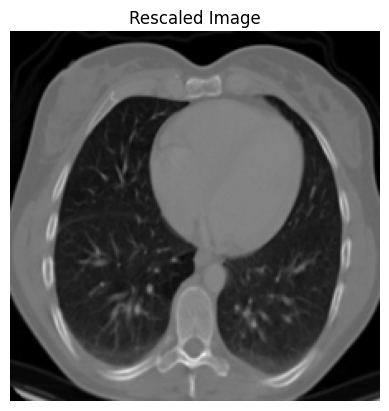

In [39]:
from PIL import Image
import numpy as np

def rescale_image(image_path, target_size):
    # 1. Load the image
    img = Image.open(image_path)

    # 2. Convert RGBA to RGB if necessary
    if img.mode == 'RGBA':
        img = img.convert('RGB')  # Remove alpha channel

    # 3. Resize the image to the target size (e.g., (height, width))
    img_resized = img.resize(target_size, Image.BILINEAR)

    # 4. Convert the image to a NumPy array
    img_array = np.array(img_resized)

    # 5. Rescale pixel values to [0, 1] range
    img_rescaled = img_array / 255.0

    # 6. Add batch dimension (for inference in models expecting batch input)
    img_rescaled = np.expand_dims(img_rescaled, axis=0)  # Shape: (1, height, width, channels)

    return img_rescaled,img_array  


image_path = r"D:\F drive\learning\Data Science\FSDS_New_batch_2023\MLOPS_project\LIVE_mlops_projects\chest_Disease_DL_project\artifacts\data_ingestion\Data\valid\adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib\000108 (7).png"

target_size = (224, 224)  # Example target size (height, width)
rescaled_image,img_array   = rescale_image(image_path, target_size)

print("Rescaled image shape:", rescaled_image.shape)  # Expected: (1, 224, 224, 3) for RGB images

plt.imshow(img_array)
plt.title("Rescaled Image")
plt.axis('off')  # Hide axes for better visualization
plt.show()

In [36]:
from PIL import Image
import numpy as np

def rescale_image(image_path, target_size):
    # 1. Load the image
    img = Image.open(image_path)

    # 2. Convert RGBA to RGB if necessary
    if img.mode == 'RGBA':
        img = img.convert('RGB')  # Remove alpha channel

    # 3. Resize the image to the target size (e.g., (height, width))
    img_resized = img.resize(target_size, Image.BILINEAR)

    # 4. Convert the image to a NumPy array
    img_array = np.array(img_resized)

    # 5. Rescale pixel values to [0, 1] range
    img_rescaled = img_array / 255.0

    # 6. Add batch dimension (for inference in models expecting batch input)
    img_rescaled = np.expand_dims(img_rescaled, axis=0)  # Shape: (1, height, width, channels)

    return img_rescaled

# Usage
image_path = r"D:\F drive\learning\Data Science\FSDS_New_batch_2023\MLOPS_project\LIVE_mlops_projects\chest_Disease_DL_project\artifacts\data_ingestion\Data\valid\adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib\000108 (7).png"
target_size = (224, 224)  # Example target size (height, width)
rescaled_image = rescale_image(image_path, target_size)

print("Rescaled image shape:", rescaled_image.shape)  # Expected: (1, 224, 224, 3) for RGB images


Rescaled image shape: (1, 224, 224, 3)


In [38]:
import mlflow
logged_model = 'runs:/fc8830d5cff540f49a9333827c8f53ff/model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model, suppress_warnings = True)

data = rescaled_image

# Predict on a Pandas DataFrame.
import pandas as pd
loaded_model.predict(rescaled_image)

c:\Users\Admin\.conda\envs\chest\lib\site-packages\keras\backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


1/1 [==============================] - 1s 1s/step


array([[1., 0.]], dtype=float32)